# Code Optimization
- __Numba__
- __Cython__

In [13]:
import numba

# don't have to explicitly import Cython.
# can use pyximport library (provided by Cython) & register an import hook.
# enables us to import Cython files (.pyx) directly.

import pyximport

# still useful to explicitly import Cython:

import cython

import numpy as np
import matplotlib.pyplot as plt

### Numba
* Don't have to alter Python code to see speedup.
* Converts pure Python to LLVM
* use @numba.jit decorator function - enables JIT compilation into optimized code
* very useful when Python code dominated by loops that can't be vectorized.

In [2]:
# loops in Python = notoriously slow due to dynamic typing & overhead
# let's benchmark simple algorithm.

def py_sum(data):
    s=0
    for d in data:
        s += d
    return s

In [3]:
data = np.random.randn(50000)
%timeit py_sum(data)

4.36 ms ± 36.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [4]:
# verify py_sum returns same result as NumPy sum function:
# if no error, we're good.
assert abs(py_sum(data) - np.sum(data)) < 1e-10

In [5]:
# benchmark NumPy sum function the same way
%timeit np.sum(data)

22.2 µs ± 120 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [6]:
# another example - accumulative sums:

def py_cumsum(data):
    out = np.zeros_like(data)
    s=0
    for n in range(len(data)):
        s += data[n]
        out[n] = s
    return out

%timeit py_cumsum(data)

10 ms ± 142 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [7]:
%timeit np.cumsum(data)

139 µs ± 349 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [8]:
# activate JIT compilation:
# 1) verify same results
# 2) run benchmark

@numba.jit
def jit_sum(data):
    s=0
    for d in data:
        s += d
    return s

# jit_sum should be ~300X faster than NumPy equivalent.

assert abs(jit_sum(data) - np.sum(data)) < 1e-10
%timeit jit_sum(data)

45.8 µs ± 111 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [9]:
# can also apply JIT decorator after the fact:

jit_cumsum = numba.jit()(py_cumsum)

assert np.allclose(np.cumsum(data), jit_cumsum(data))
%timeit jit_cumsum(data)

59.1 µs ± 163 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [10]:
# example: Julia fractal
# three nested loops - in Python, VERY slow.

def py_julia_fractal(z_re, z_im, j):
    for m in range(len(z_re)):
        for n in range(len(z_im)):
            z = z_re[m] + 1j * z_im[n]
            for t in range(256):
                z = z ** 2 - 0.05 + 0.68j
                if np.abs(z) > 2.0:
                    j[m,n] = t
                    break
                    
# JIT optimization options:
# default: graceful fallback to python if not possible to optimize
# nopython=true: JIT compilation fails if Numba can't optimize.
# can use 'locals' keyword to define variable types in the function body.

jit_julia_fractal = numba.jit(nopython=True)(py_julia_fractal)

In [11]:
# note how NumPy arrays are defined outside the function.
# this helps NumPy know the datatypes involved - aids code efficiency for JIT compilation.

N = 1024
j = np.zeros((N,N), np.int64)
z_real = np.linspace(-1.5, 1.5, N)
z_imag = np.linspace(-1.5, 1.5, N)

jit_julia_fractal(z_real, z_imag, j) # result stored in j

Text(0, 0.5, '$\\mathrm{Im}(z)$')

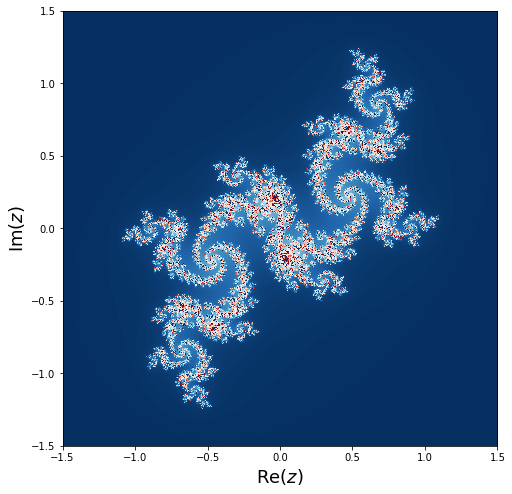

In [14]:
fig, ax = plt.subplots(figsize=(8,8))
ax.imshow(j, cmap=plt.cm.RdBu_r, extent=[-1.5,1.5,-1.5,1.5])
ax.set_xlabel("$\mathrm{Re}(z)$", fontsize=18)
ax.set_ylabel("$\mathrm{Im}(z)$", fontsize=18)

In [17]:
# %timeit py_julia_fractal(z_real, z_imag, j)
# interrrupted via keyboard due to execution length

In [16]:
%timeit jit_julia_fractal(z_real, z_imag, j)

245 ms ± 2.08 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Numba.vectorize
* Generates a vectorized function from a kernel written for scalar inputs/outputs.
* Example: Heavyside step function

In [14]:
def py_Heavyside(x):
    if x == 0.0:
        return 0.5
    if x < 0.0:
        return 0.0
    else:
        return 1.0
    
# only works with scalars. need to iterate to work with arrays:

x = np.linspace(-2,2,50001)
%timeit [py_Heavyside(xx) for xx in x]

13 ms ± 89.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [15]:
# not great. let's use vectorize.

np_vec_Heavyside = np.vectorize(py_Heavyside)
np_vec_Heavyside(x)

array([0., 0., 0., ..., 1., 1., 1.])

In [16]:
%timeit np_vec_Heavyside(x)

7.47 ms ± 22.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [17]:
# helps, but not much. next: Numpy array expression.

def np_Heavyside(x):
    return (x>0.0) + (x==0.0)/2.0

%timeit np_Heavyside(x)

186 µs ± 572 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [19]:
# best: Numba, vectorize decorator for two signatures.

@numba.vectorize(
    [numba.float32(numba.float32),
     numba.float64(numba.float64)])
def jit_Heavyside(x):
    if x == 0.0:
        return 0.5
    if x < 0:
        return 0.0
    else:
        return 1.0
    
%timeit jit_Heavyside(x)

27.8 µs ± 41.4 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


### Cython

* Cython methodology completely different from Numba.
* Extends Python - provides explicit & static data type declarations.
* Enables efficient converstion to C/C++ code for compilation into Python extension mods.
* Use cases: code speedup, and building library wrappers.
* Uses ahead-of-time (not JIT) compilation
* Requires Cython-specific compilation pipeline (__cython__ cmnd line tool)

In [21]:
!head cy_sum.pyx

# cy_sum.pyx

def cy_sum(data):
    s = 0.0
    for d in data:
        s += d
    return s

In [22]:
!head setup.py

# usage: $python setup.py build_ext --inplace 
# instructs distutils to build extension module in same directory as source.

from distutils.core import setup
from Cython.Build import cythonize
import numpy as np

setup(ext_modules=cythonize('cy_sum.pyx'),
    include_dirs=[np.get_include()],
    requires=['Cython','numpy'])

In [23]:
!python setup.py build_ext --inplace

Compiling cy_sum.pyx because it changed.
[1/1] Cythonizing cy_sum.pyx
running build_ext
building 'cy_sum' extension
creating build
creating build/temp.linux-x86_64-3.6
gcc -pthread -B /home/bjpcjp/anaconda3/compiler_compat -Wl,--sysroot=/ -Wsign-compare -DNDEBUG -g -fwrapv -O3 -Wall -Wstrict-prototypes -fPIC -I/home/bjpcjp/anaconda3/lib/python3.6/site-packages/numpy/core/include -I/home/bjpcjp/anaconda3/include/python3.6m -c cy_sum.c -o build/temp.linux-x86_64-3.6/cy_sum.o
gcc -pthread -shared -B /home/bjpcjp/anaconda3/compiler_compat -L/home/bjpcjp/anaconda3/lib -Wl,-rpath=/home/bjpcjp/anaconda3/lib -Wl,--no-as-needed -Wl,--sysroot=/ build/temp.linux-x86_64-3.6/cy_sum.o -o /home/bjpcjp/projects/code/python-numerical-backup/Numeric-Python/cy_sum.cpython-36m-x86_64-linux-gnu.so


In [24]:
!ls cy_sum*

cy_sum.c  cy_sum.cpython-36m-x86_64-linux-gnu.so  cy_sum.pyx


In [25]:
from cy_sum import cy_sum

In [26]:
cy_sum(data)

21.748331210974925

In [27]:
%timeit cy_sum(data)

3.73 ms ± 18.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [28]:
%timeit py_sum(data)

4.29 ms ± 12.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


* Speedup ~25%. Nice, but worth the trouble?
* Let's try another approach.

In [30]:
!head cy_cumsum.pyx

# cy_cumsum.pyx
cimport numpy
import numpy

def cy_cumsum(data):
    out = numpy.zeros_like(data)
    s = 0
    for n in range(len(data)):
        s += data[n]
        out[n] =s


* Explicit compilation (Cython to Python, above) is useful for distributing prebuilt Cython modules (no need for Cython installation to use extension module).
* Alternative: invoke Cython compilation during import (via __pyximport__ library).

In [32]:
# modifies Python import statement - adds Cython pyx file support
pyximport.install(setup_args=dict(include_dirs=np.get_include()))

(None, None)

In [33]:
from cy_cumsum import cy_cumsum

In [34]:
%timeit cy_cumsum(data)

4.14 ms ± 11.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [35]:
%timeit py_cumsum(data)

9.92 ms ± 310 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


* Speedup ~2X. Nice, but worth the trouble?
* One more alternative.

In [38]:
# Load cython extension to Jupyter Notebook:
%load_ext cython

In [41]:
%%cython
def cy_sum(data):
    s = 0.0
    for d in data:
        s += d
    return s

In [42]:
%timeit cy_sum(data)

3.71 ms ± 8.88 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [43]:
%timeit py_sum(data)

4.3 ms ± 18.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### Cython - computational tricks & tips, #1

- @cython.boundscheck(False), @cython.wraparound(False) disables boundary checks on NumPy array boundary checking. (Increased bug risk.)
- Add type declarations wherever possible, via Cython's __cdef__ keyword.

In [44]:
%%cython
cimport numpy
cimport cython

@cython.boundscheck(False)
@cython.wraparound(False)

def cy_sum(numpy.ndarray[numpy.float64_t, ndim=1] data):
    cdef numpy.float64_t s = 0.0
    cdef int n, N = len(data)
    for n in range(N):
        s += data[n]
    return s



In [45]:
%timeit cy_sum(data)

45.8 µs ± 216 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [46]:
%timeit py_sum(data)

8.83 ms ± 107 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [49]:
%%cython
cimport numpy
import numpy
cimport cython

ctypedef numpy.float64_t FTYPE_t

@cython.boundscheck(False)
@cython.wraparound(False)

def cy_cumsum(numpy.ndarray[FTYPE_t, ndim=1] data):
    cdef int n, N = data.size
    cdef numpy.ndarray[FTYPE_t, ndim=1] out = numpy.zeros(N, dtype=data.dtype)
    cdef numpy.float64_t s = 0.0
    
    for n in range(N):
        s += data[n]
        out[n] = s
    return out

In [50]:
%timeit cy_cumsum(data)

84.7 µs ± 102 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [51]:
%timeit py_cumsum(data)

18.9 ms ± 38.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


* Now we've got significant speedup over previous cumsum(data) iteration.
* Also signficantly faster than NumPy's builtin cumsum() function.
* Adding explicit data type declarations adds performance, but loses flexibility. The pure Python implementation accepts lists & arrays, integers & floating-point.
* Cython has a workaround via its __ctypedef fused__ keyword.

In [52]:
%%cython
cimport numpy
cimport cython

#ctypedef numpy.float64_t FTYPE_t
ctypedef fused I_OR_F_t:
    numpy.int64_t
    numpy.float64_t

@cython.boundscheck(False)
@cython.wraparound(False)

def cy_fused_sum(numpy.ndarray[I_OR_F_t, ndim=1] data):
    cdef I_OR_F_t s = 0
    cdef int n, N = len(data)
    for n in range(N):
        s += data[n]
    return s

In [53]:
# now we should have code that runs on both floating-point & integer data:
cy_fused_sum(np.array([1.0, 2.0, 3.0, 4.0, 5.0]))

15.0

In [54]:
cy_fused_sum(np.array([1, 2, 3, 4, 5]))

15

* Final example, using Julia fractal algorithm
* Again using data type declarations & array range disabling decorators
* Now using Cython __inline__ keyword to define a function.
* __cdef__ keyword
* __cpdef__: 

In [57]:
%%cython
cimport numpy
cimport cython

cdef inline double abs2(double complex z):
    return z.real * z.real + z.imag * z.imag

@cython.boundscheck(False)
@cython.wraparound(False)

def cy_julia_fractal(numpy.ndarray[numpy.float64_t, ndim=1] z_re,
                     numpy.ndarray[numpy.float64_t, ndim=1] z_im,
                     numpy.ndarray[numpy.int64_t, ndim=2] j):
    cdef int m, n, t, M = z_re.size, N = z_im.size
    cdef double complex z
    for m in range(M):
        for n in range(N):
                z = z_re[m] + 1.0j * z_im[n]
                for t in range(256):
                    z = z**2 - 0.05 + 0.68j
                    if abs2(z) > 4.0:
                        j[m,n] = t
                        break

In [58]:
N      = 1024
j      = np.zeros((N,N), dtype=np.int64)
z_real = np.linspace(-1.5,1.5,N)
z_imag = np.linspace(-1.5,1.5,N)

%timeit(cy_julia_fractal(z_real, z_imag, j))

119 ms ± 36.9 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [59]:
%timeit(jit_julia_fractal(z_real, z_imag, j))

331 ms ± 12.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Using Cython to wrap compiled C/C++ libraries
* Below: calling acos function from std C library (math.h)
* Use __cdef extern__ keyword to get function declarations.

In [60]:
%%cython
cdef extern from "math.h":
    double acos(double)
    
def cy_acos1(double x):
    return acos(x)

In [61]:
%timeit cy_acos1(0.5)

81.4 ns ± 0.279 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)


* Cython already provides the __libc__ module to aid this use case:

In [62]:
%%cython
from libc.math cimport acos

def cy_acos2(double x):
    return acos(x)

In [63]:
%timeit cy_acos2(0.5)

90.5 ns ± 0.916 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)


* for comparison to NumPy:

In [64]:
from numpy import arccos
%timeit arccos(0.5)

1.07 µs ± 2.42 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [65]:
from math import acos
%timeit acos(0.5)

88.8 ns ± 0.263 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)
